In [2]:
### IMPORTS ###
from typing import Callable, Sequence, Any
from functools import partial
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import optax
import jaxopt
from jax.scipy.stats.norm import logpdf
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock
print('cuda?', jax.devices(), jax.devices()[0].device_kind)

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

fixed_seed = 12345
rng = jax.random.PRNGKey(fixed_seed)

cuda? [CpuDevice(id=0)] cpu


In [3]:
### CONFIGURATION ###
# Test-configuration
dataset_size = 128
test_resolution = 512

# Train-configuration
num_posterior_mc = 1  # number of alatents to sample from p(Z | X, Y)
batch_size = 128  # number of functions to sample from p(Z)

kl_penalty = 1e-4  # Note to self: magnitude of the kl-divergence can take over in the loss
num_target_samples = 32
num_context_samples = 64

In [4]:
def f(
    key: flax.typing.PRNGKey, 
    x: jax.Array, 
    noise_scale: float = 0.2, 
    mixture_prob: float = 0.5, 
    corrupt: bool = True
):
    noise = jax.random.normal(key, x.shape) * noise_scale
    return(-2-jnp.cos(2 * jnp.pi * x)) + corrupt * noise

rng, key_data, key_test, key_x = jax.random.split(rng, 4)
keys_data = jax.random.split(key_data, (dataset_size,))
keys_test = jax.random.split(key_test, (test_resolution,))
xs_input = jax.random.uniform(key_x, (dataset_size,)) * 2 - 1
ys_input = jax.vmap(f)(keys_data, xs_input)
x_test_input = jnp.linspace(-1, 1, test_resolution)
y_test = jax.vmap(partial(f, corrupt=False))(keys_test, x_test_input)

In [5]:
### CONSTRUCT THE STANDARD NP MODEL ###
embedding_xs = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_ys = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_both = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)

projection_posterior = NonLinearMVN(MLP([128, 64], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True))
output_model = nn.Sequential([
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    nn.Dense(2)
])
projection_outputs = NonLinearMVN(output_model)

posterior_aggregator = MeanAggregator(projection_posterior)

standard_model = MixtureNeuralProcess(
    embedding_xs, embedding_ys, embedding_both, 
    posterior_aggregator, 
    projection_outputs
)
rng, key = jax.random.split(rng)
#NOTE xs - xs_input
#params = standard_model.init({'params': key, 'default': key}, xs_input[:, None], ys_input[:, None], xs_input[:3, None])

In [6]:
### DEFINE THE LOSS ###
# Define how the model loss should be computed
def posterior_loss(
    params: flax.typing.VariableDict,
    key: flax.typing.PRNGKey,
    batch,
    mask = None,
    
):
    X = batch[0]
    y = batch[1]
    x_test = batch[2]
    y_test = batch[3]
    #print(X.shape, " ", y.shape, " ", x_test.shape, " ", y_test.shape)
    # Compute ELBO over batch of datasets
    key_data, key_model = jax.random.split(key)
    elbos = jax.vmap(partial(
        standard_model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=standard_model.elbo
    ))(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, X.shape[0])}
    )
    ans = -elbos.mean()
    return ans

In [7]:
### JIT STEP ###
@jax.jit
def step(
    theta: flax.typing.VariableDict, 
    opt_state: optax.OptState, 
    random_key: flax.typing.PRNGKey,
    current_batch,
    current_mask = None
) -> tuple[flax.typing.VariableDict, optax.OptState, jax.Array]:
    # Implements a generic SGD Step
    #CHANGE DEPENDING ON MODEL OR TEACHER BEING TRAINED!!!!
    value, grad = jax.value_and_grad(posterior_loss, argnums=0)(theta, random_key, current_batch, current_mask)
    
    updates, opt_state = optimizer.update(grad, opt_state, theta)
    theta = optax.apply_updates(theta, updates)
    #print("step2", current_batch[0], " ", current_batch[0].shape)
    return theta, opt_state, value

In [8]:
### JIT SCAN_TRAIN ###
def body(carry, batch):
    params, opt_state, key = carry
    key_carry, key_step = jax.random.split(key)
    #print("1 ", batch[0].shape, " ", batch.shape)
    X, x_test = jnp.split(batch[0], indices_or_sections=(num_context_samples, ), axis=1)
    y, y_test = jnp.split(batch[1], indices_or_sections=(num_context_samples, ), axis=1)
    #print(X.shape)
    #print(x_test.shape)
    #print(y.shape)
    #print(y_test.shape)
    mask = None
    if len(batch) >= 3:
        mask = batch[2]
    #print("bod_shape", X.shape, " ", x_test.shape)
    params, opt_state, value = step(params, opt_state, key_step, (X,y, x_test,y_test ), mask)

    return (params, opt_state, key_carry), value

jax.jit
def scan_train(params, opt_state, key, batches):
    
    last, out = jax.lax.scan(body, (params, opt_state, key), batches)

    params, opt_state, _ = last
    
    return params, opt_state, out

In [9]:
'''def cross_entropy_error(model, params, x_context, y_context, x_target, y_target , rng , k):
    y_means = jax.vmap(partial(
        standard_model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=standard_model.elbo
    ))(
        x_context, y_context, x_target, y_target, rngs={'default': jax.random.split(rng, x_context.shape[0])}
    )
    print(y_means.shape)

    # Lets compute the log likelihood of the target points given the means and stds

    # Ensure y_means and y_stds are squeezed correctly
    y_means = jnp.squeeze(y_means, axis=-1) if k > 1 else jnp.squeeze(y_means)
    y_stds = jnp.squeeze(y_stds, axis=-1) if k > 1 else jnp.squeeze(y_stds)
    full_y = jnp.squeeze(y_target, axis=-1) if k > 1 else jnp.squeeze(y_target) 

    log_pdf = logpdf(full_y, y_means,y_stds) 
    return -jnp.mean(log_pdf)'''



def RMSE_means(model, params, x_context, y_context, x_target, y_target, rng, k):
    #print(x_context.shape)
    #print(y_context.shape)
    #print(x_target.shape)
    #print(params['params']['posterior_fun']['likelihood']['projection']['Dense_0']['kernel'].shape)
    #y_means, y_stds = model.apply(params, x_context, y_context, x_target,k=k, rngs={'default': rng}) 
    #print("rmse ", x_context.shape, " ", y_context.shape, " ", x_target.shape, " ", y_target.shape)
    y_means = jax.vmap(partial(
        standard_model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=standard_model.elbo
    ))(
        x_context, y_context, x_target, y_target, rngs={'default': jax.random.split(rng, x_context.shape[0])}
    )
    
    return jnp.sqrt(jnp.mean((y_means - y_target)**2))

In [10]:
### TRAINING ###
#mini_batches should have 4 values: xs1, ys1, xs2, ys2 5000 times.
#validation = in task, evaluation = out of task
def training_optimization_with_curriculum(input_rng, training_mini_batches, validation_mini_batches, evaluation_mini_batches):
    # Initialize the Optimization.
    scan_chunk = 2
    
    rng, key = jax.random.split(input_rng)
    
    #Setup 0
    params = params0 = standard_model.init(
        {'params': key, 'default': key}, 
        xs_input[:, None], ys_input[:, None], x_test_input[:1, None]
    )
    optimizer = optax.chain(
        optax.clip(.1),
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
    )
    opt_state = optimizer.init(params)

    best, best_params = jnp.inf, params
    losses = list()
    in_task_rmse = list()
    out_task_rmse = list()
    in_task_ece = list()
    out_task_ece = list()
    for i in (pbar := tqdm.trange(5000 // scan_chunk, desc='Optimizing params. ')):
        xs1, ys1, xs2, ys2 = training_mini_batches[i]
        batches = jnp.asarray([(xs1, ys1), (xs2, ys2)])
        params_new, opt_state, loss_arr = scan_train(params, opt_state, key, batches)

        in_xs1, in_ys1, in_xs2, in_ys2 = validation_mini_batches[i]
        out_xs1, out_ys1, out_xs2, out_ys2 = evaluation_mini_batches[i]
        
        k = 1
        
        if i % 5 == 0:
            x_context, x_target = jnp.split(in_xs1, indices_or_sections=(num_context_samples, ), axis=1)
            y_context, y_target = jnp.split(in_ys1, indices_or_sections=(num_context_samples, ), axis=1) 
            in_task_rmse_arr = RMSE_means(standard_model, params_new, x_context, y_context, x_target, y_target, rng, k)
        #in_task_ece_arr = cross_entropy_error(standard_model, params_new, x_context, y_context, x_target, y_target , rng , k)
            x_context, x_target = jnp.split(out_xs2, indices_or_sections=(num_context_samples, ), axis=1)
            y_context, y_target = jnp.split(out_ys2, indices_or_sections=(num_context_samples, ), axis=1) 
            out_task_rmse_arr = RMSE_means(standard_model, params_new, x_context, y_context, x_target, y_target, rng, k)
        #out_task_ece_arr = cross_entropy_error(standard_model, params_new, x_context, y_context, x_target, y_target , rng , k)
            in_task_rmse.append(in_task_rmse_arr)
            out_task_rmse.append(out_task_rmse_arr)
        #in_task_ece.append(in_task_ece_arr)
        #out_task_ece.append(out_task_ece_arr)
        
        #x_context, x_target = jnp.split(in_xs2, indices_or_sections=(num_context_samples, ), axis=1)
        #y_context, y_target = jnp.split(in_ys2, indices_or_sections=(num_context_samples, ), axis=1) 
        #in_task_rmse_arr = RMSE_means(standard_model, params_new, x_context, y_context, x_target, y_target, rng, k)
        #in_task_ece_arr = cross_entropy_error(standard_model, params_new, x_context, y_context, x_target, y_target , rng , k)
        #x_context, x_target = jnp.split(out_xs2, indices_or_sections=(num_context_samples, ), axis=1)
        #y_context, y_target = jnp.split(out_ys2, indices_or_sections=(num_context_samples, ), axis=1) 
        #out_task_rmse_arr = RMSE_means(standard_model, params_new, x_context, y_context, x_target, y_target, rng, k)
        #out_task_ece_arr = cross_entropy_error(standard_model, params_new, x_context, y_context, x_target, y_target , rng , k)
        #in_task_rmse.append(in_task_rmse_arr)
        #out_task_rmse.append(out_task_rmse_arr)
        #in_task_ece.append(in_task_ece_arr)
        #out_task_ece.append(out_task_ece_arr)
        
        losses.append(loss_arr)

        if loss_arr.min() < best:
            best = loss_arr.min()
            best_params = params_new
        
        if jnp.isnan(loss_arr).any():
            print("break")
            break
        else:
            params = params_new
        
        pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')
    params = best_params
    losses = jnp.asarray(losses).ravel()
    in_task_rmse = jnp.asarray(in_task_rmse).ravel()
    out_task_rmse = jnp.asarray(out_task_rmse).ravel()
    in_task_ece = jnp.asarray(in_task_ece).ravel()
    out_task_ece = jnp.asarray(out_task_ece).ravel()
    return params, losses, in_task_rmse, out_task_rmse, #in_task_ece, out_task_ece

In [100]:
evaluation_mini_batches = 0
with open('saved_batches/evaluation_batches.pkl', 'rb') as file:
    evaluation_mini_batches = pickle.load(file)
    
for model_training_number in range(1):
    #Load data
    training_mini_batches = 0
    validation_mini_batches = 0
    with open(f'saved_batches/train_no_curr_{model_training_number}.pkl', 'rb') as file:
        training_mini_batches = pickle.load(file)
    with open(f'saved_batches/validation_data_{model_training_number}.pkl', 'rb') as file:
        validation_mini_batches = pickle.load(file)
    print(f"{model_training_number} data is loaded!")
    
    #Setup
    params = params0 = standard_model.init(
        {'params': key, 'default': key}, 
        xs_input[:, None], ys_input[:, None], x_test_input[:1, None]
    )
    optimizer = optax.chain(
        optax.clip(.1),
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
    )
    opt_state = optimizer.init(params)
    
    #Training
    trained_params, losses, in_task_rmse, out_task_rmse = training_optimization_with_curriculum(rng, training_mini_batches, validation_mini_batches, evaluation_mini_batches)
    
    #Save data
    with open(f'saved_results/normal_nocurr_params_{model_training_number}.pkl', 'wb') as document_to_write:
        pickle.dump(trained_params, document_to_write)
    with open(f'saved_results/normal_nocurr_losses_{model_training_number}.pkl', 'wb') as document_to_write:
        pickle.dump(losses, document_to_write)
    
    with open(f'saved_results/normal_nocurr_intask_rmse_{model_training_number}.pkl', 'wb') as document_to_write:
        pickle.dump(in_task_rmse, document_to_write)
    #with open(f'saved_results/normal_nocurr_intask_ece_{model_training_number}.pkl', 'wb') as document_to_write:
    #    pickle.dump(in_task_ece, document_to_write)
    with open(f'saved_results/normal_nocurr_outtask_rmse_{model_training_number}.pkl', 'wb') as document_to_write:
        pickle.dump(out_task_rmse, document_to_write)
    #with open(f'saved_results/normal_nocurr_outtask_ece_{model_training_number}.pkl', 'wb') as document_to_write:
    #    pickle.dump(out_task_ece, document_to_write)

0 data is loaded!


Optimizing params. Loss: -0.7504: 100%|██████████| 2500/2500 [32:08<00:00,  1.30it/s]


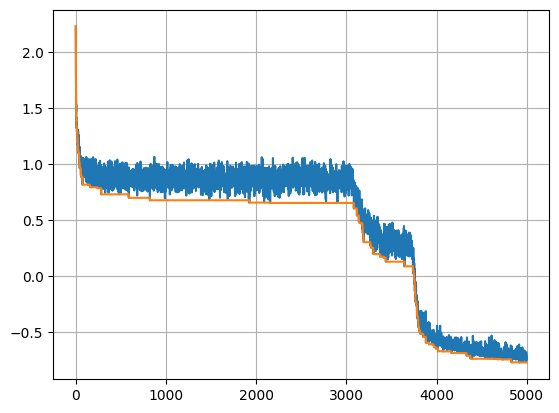

In [111]:
### PLOT LOSSES ###
with open(f'saved_results/normal_nocurr_losses_0.pkl', 'rb') as document_to_write:
    losses = pickle.load(document_to_write)
losses = jnp.asarray(losses).ravel()
plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()

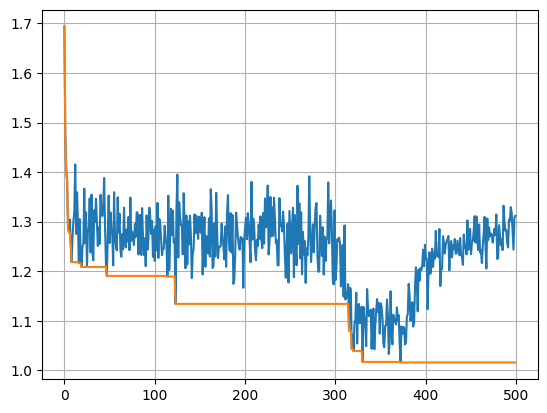

In [115]:
### PLOT LOSSES ###
with open(f'saved_results/normal_nocurr_intask_rmse_0.pkl', 'rb') as document_to_write:
    in_task_rmse = pickle.load(document_to_write)
losses = jnp.asarray(in_task_rmse).ravel()
plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()

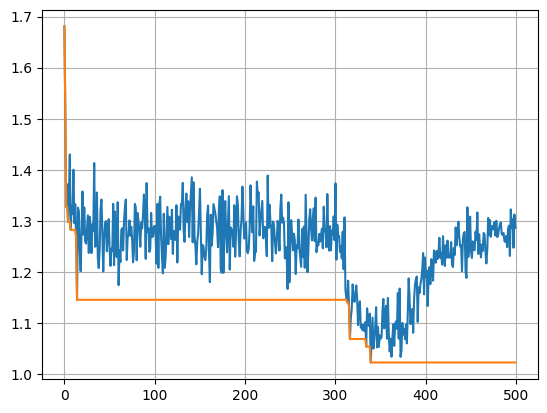

In [114]:
### PLOT LOSSES ###
with open(f'saved_results/normal_nocurr_outtask_rmse_0.pkl', 'rb') as document_to_write:
    out_task_rmse = pickle.load(document_to_write)
losses = jnp.asarray(out_task_rmse).ravel()
plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()

In [12]:
evaluation_mini_batches = 0
with open('saved_batches/evaluation_batches.pkl', 'rb') as file:
    evaluation_mini_batches = pickle.load(file)
    
for model_training_number in range(1):
    #Load data
    training_mini_batches = 0
    validation_mini_batches = 0
    with open(f'saved_batches/train_fixedexp_curr_{model_training_number}.pkl', 'rb') as file:
        training_mini_batches = pickle.load(file)
    with open(f'saved_batches/validation_data_{model_training_number}.pkl', 'rb') as file:
        validation_mini_batches = pickle.load(file)
    print(f"{model_training_number} data is loaded!")
    
    #Setup
    params = params0 = standard_model.init(
        {'params': key, 'default': key}, 
        xs_input[:, None], ys_input[:, None], x_test_input[:1, None]
    )
    optimizer = optax.chain(
        optax.clip(.1),
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
    )
    opt_state = optimizer.init(params)
    
    #Training
    trained_params, losses, in_task_rmse, out_task_rmse = training_optimization_with_curriculum(rng, training_mini_batches, validation_mini_batches, evaluation_mini_batches)
    
    #Save data
    with open(f'saved_results/normal_nocurr_params_{model_training_number}.pkl', 'wb') as document_to_write:
        pickle.dump(trained_params, document_to_write)
    with open(f'saved_results/normal_nocurr_losses_{model_training_number}.pkl', 'wb') as document_to_write:
        pickle.dump(losses, document_to_write)
    
    with open(f'saved_results/normal_nocurr_intask_rmse_{model_training_number}.pkl', 'wb') as document_to_write:
        pickle.dump(in_task_rmse, document_to_write)
    #with open(f'saved_results/normal_nocurr_intask_ece_{model_training_number}.pkl', 'wb') as document_to_write:
    #    pickle.dump(in_task_ece, document_to_write)
    with open(f'saved_results/normal_nocurr_outtask_rmse_{model_training_number}.pkl', 'wb') as document_to_write:
        pickle.dump(out_task_rmse, document_to_write)
    #with open(f'saved_results/normal_nocurr_outtask_ece_{model_training_number}.pkl', 'wb') as document_to_write:
    #    pickle.dump(out_task_ece, document_to_write)

0 data is loaded!


Optimizing params. Loss: 0.8924: 100%|██████████| 2500/2500 [33:06<00:00,  1.26it/s]  


In [12]:
evaluation_mini_batches = 0
with open('saved_batches/evaluation_batches.pkl', 'rb') as file:
    evaluation_mini_batches = pickle.load(file)
    
for model_training_number in range(1):
    #Load data
    training_mini_batches = 0
    validation_mini_batches = 0
    with open(f'saved_batches/train_step_curr_{model_training_number}.pkl', 'rb') as file:
        training_mini_batches = pickle.load(file)
    with open(f'saved_batches/validation_data_{model_training_number}.pkl', 'rb') as file:
        validation_mini_batches = pickle.load(file)
    print(f"{model_training_number} data is loaded!")
    
    #Setup
    params = params0 = standard_model.init(
        {'params': key, 'default': key}, 
        xs_input[:, None], ys_input[:, None], x_test_input[:1, None]
    )
    optimizer = optax.chain(
        optax.clip(.1),
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
    )
    opt_state = optimizer.init(params)
    
    #Training
    trained_params, losses, in_task_rmse, out_task_rmse = training_optimization_with_curriculum(rng, training_mini_batches, validation_mini_batches, evaluation_mini_batches)
    
    #Save data
    with open(f'saved_results/normal_step_params_{model_training_number}.pkl', 'wb') as document_to_write:
        pickle.dump(trained_params, document_to_write)
    with open(f'saved_results/normal_step_losses_{model_training_number}.pkl', 'wb') as document_to_write:
        pickle.dump(losses, document_to_write)
    
    with open(f'saved_results/normal_step_intask_rmse_{model_training_number}.pkl', 'wb') as document_to_write:
        pickle.dump(in_task_rmse, document_to_write)
    #with open(f'saved_results/normal_nocurr_intask_ece_{model_training_number}.pkl', 'wb') as document_to_write:
    #    pickle.dump(in_task_ece, document_to_write)
    with open(f'saved_results/normal_step_outtask_rmse_{model_training_number}.pkl', 'wb') as document_to_write:
        pickle.dump(out_task_rmse, document_to_write)
    #with open(f'saved_results/normal_nocurr_outtask_ece_{model_training_number}.pkl', 'wb') as document_to_write:
    #    pickle.dump(out_task_ece, document_to_write)

0 data is loaded!


Optimizing params. :   0%|          | 0/2500 [00:00<?, ?it/s]

In [10]:
def posterior_loss_curr_eval_teacher(
    params: flax.typing.VariableDict,
    key: flax.typing.PRNGKey,
    xs,
    ys
):
    # Split into context- and target-points.
    X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)
    y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)
    #print(batch[0].shape, " ", batch[1].shape, " ", batch[2].shape,)

    #print("Shapes of tensors being mapped:", X.shape, y.shape, x_test.shape, y_test.shape)
    # Compute ELBO over batch of datasets
    elbos = jax.vmap(partial(
        standard_model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=standard_model.elbo
    ))(
        X, y, x_test, y_test, rngs={'default': jax.random.split(rng, X.shape[0])}
    )
    
    return -elbos

In [13]:
###ORDER THE DATA###
def sort_for_curriculum(teacher_params, input_rng, xss_yss, posterior_loss_curr_eval_t):
    all_xs = jnp.concatenate([xs for xs, ys in xss_yss])
    all_ys = jnp.concatenate([ys for xs, ys in xss_yss])
    print("all_xs and all_ys is ready!")
    #it would be cool if I could add some progress bar here!
    diffs = jnp.concatenate([posterior_loss_curr_eval_t(teacher_params, input_rng, xs, ys) for xs, ys in xss_yss])
    print("difficulties calculated!")
    sorted_indices = jnp.argsort(diffs)
    all_xs_sorted = all_xs[sorted_indices] #is this even possible?
    all_ys_sorted = all_ys[sorted_indices]
    print("sorting done!")
    return all_xs_sorted, all_ys_sorted #all_xs_sorted, all_ys_sorted

In [15]:
for i in range(1):    
    xss_yss_unordered = []
    with open(f"saved_datasets/training_data_{i}.pkl", "rb") as file:
        xss_yss_unordered = pickle.load(file)
    with open(f'saved_results/normal_nocurr_params_0.pkl', 'rb') as document_to_write:
        trained_params = pickle.load(document_to_write)
    #read in trained params
    all_xs_teacher_sorted, all_ys_teacher_sorted = sort_for_curriculum(trained_params, rng, xss_yss_unordered, posterior_loss_curr_eval_teacher)
    with open(f"saved_datasets/ordered_normal_training_data_xs_{i}.pkl", "wb") as file:
        pickle.dump(all_xs_teacher_sorted, file)
    with open(f"saved_datasets/ordered_normal_training_data_ys_{i}.pkl", "wb") as file:
        pickle.dump(all_ys_teacher_sorted, file)

all_xs and all_ys is ready!
difficulties calculated!
sorting done!


In [16]:
evaluation_mini_batches = 0
with open('saved_batches/evaluation_batches.pkl', 'rb') as file:
    evaluation_mini_batches = pickle.load(file)
    
for model_training_number in range(1):
    #Load data
    training_mini_batches = 0
    validation_mini_batches = 0
    with open(f'saved_batches/bootstrap_fixedexp_curr_{model_training_number}.pkl', 'rb') as file:
        training_mini_batches = pickle.load(file)
    with open(f'saved_batches/validation_data_{model_training_number}.pkl', 'rb') as file:
        validation_mini_batches = pickle.load(file)
    print(f"{model_training_number} data is loaded!")
    
    #Setup
    params = params0 = standard_model.init(
        {'params': key, 'default': key}, 
        xs_input[:, None], ys_input[:, None], x_test_input[:1, None]
    )
    optimizer = optax.chain(
        optax.clip(.1),
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
    )
    opt_state = optimizer.init(params)
    
    #Training
    trained_params, losses, in_task_rmse, out_task_rmse = training_optimization_with_curriculum(rng, training_mini_batches, validation_mini_batches, evaluation_mini_batches)
    
    #Save data
    with open(f'saved_results/bootstrapped_step_params_{model_training_number}.pkl', 'wb') as document_to_write:
        pickle.dump(trained_params, document_to_write)
    with open(f'saved_results/bootstrapped_step_losses_{model_training_number}.pkl', 'wb') as document_to_write:
        pickle.dump(losses, document_to_write)
    
    with open(f'saved_results/bootstrapped_step_intask_rmse_{model_training_number}.pkl', 'wb') as document_to_write:
        pickle.dump(in_task_rmse, document_to_write)
    #with open(f'saved_results/normal_nocurr_intask_ece_{model_training_number}.pkl', 'wb') as document_to_write:
    #    pickle.dump(in_task_ece, document_to_write)
    with open(f'saved_results/bootstrapped_step_outtask_rmse_{model_training_number}.pkl', 'wb') as document_to_write:
        pickle.dump(out_task_rmse, document_to_write)
    #with open(f'saved_results/normal_nocurr_outtask_ece_{model_training_number}.pkl', 'wb') as document_to_write:
    #    pickle.dump(out_task_ece, document_to_write)

0 data is loaded!


Optimizing params. Loss: -0.7414: 100%|██████████| 2500/2500 [26:15<00:00,  1.59it/s]
